In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import truncnorm

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

# Problem Set 5

## Exercise 1

Consider the following DGP:

* $n$ observations and $p$ predictors; initially set $p=50$
* $\mathbf{X}\sim \mathcal{N}_p(\mathbf{0}, \mathbf{\Sigma})$, where $\Sigma$ is diagonal and the variances are taken normally ranging from $1$ to $2$.
* The population coefficients $\beta$ range from $0.1 \sim 0.5$. You can sample values or use eqi-spaced values.
* $\epsilon \sim N(0, 1)$

In [2]:
np.random.seed(100)
# Generate data #

# Parameters
n = 1000
p = 2

def _get_truncated_normal(mean=0, sd=1, low=1, upp=2, n_samples=2):
    """
    The function to extract random normal values from the truncated normal
    distribution (between 1 and 2).
    Default values: mean=0, sd=1, low=1, upp=2, n_samples=2. But you can change
    the values.
    """
    return truncnorm.rvs(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd, size=n_samples)

def generate_data(nobs, npre):
    """
    See above.
    """
    # Generate predictors.
    mu = np.zeros((npre,))
    X_data = np.full((nobs, npre), np.nan)
    sigma_seq = _get_truncated_normal(n_samples=npre)
    sigma = np.diag(sigma_seq)
    X_data = np.random.multivariate_normal(mu, sigma, nobs)

    # Error terms.
    epsilon =  np.random.standard_normal(nobs)

    # Coefficients.
    coe = np.random.uniform(0.1, 0.5, npre)

    # Linear model.
    y_data = X_data @ coe + epsilon
    
    return X_data, y_data, coe

In [3]:
X, y, beta= generate_data(n, p)

**a)** Calculate the principal components using the eigenvector methodology outlined in class and convince
yourself that the function `prcomp` returns the same numerical transformations that we obtain by hand.

Remark: In python we use `sklearn.decomposition.PCA` module to subsitute for the function `prcomp` in R

In [4]:
# Eigenvector methodology #

# Obtain the eigenvectors.
scale_X = scale(X, axis=0)  # Standardize X with unit variance.
X_cov = np.cov(scale_X.T)
_, X_eig = np.linalg.eig(X_cov)

# Use PCA method.
pca = PCA()
X_reduced = pca.fit_transform(scale_X)
X_comp = pca.components_.T

Note that the sign of eigenvectors are arbitrary (sometimes the sign is reverse, but still the same direction). Hence we compare two arrays in all four directions.

In [5]:
# Compare.
X_comp_sig = np.concatenate((X_comp, -X_comp), axis=1)
compa = np.full((p, 2 * p), np.nan)
for i in np.arange(p):
    for j in np.arange(2 * p):
        compa[i, j] = np.allclose(X_eig[:, i], X_comp_sig[:, j])
        
if sum(sum(compa)) == 2:
    print('Two arrays are the same.')
else:
    print('Two arrays are not the same.')

Two arrays are the same.


**b)** Perform PCR using the transformed data and compare test errors using an independent test set with
ordinary least squares and ridge regression (use cross-validation to chose $\lambda$).

In [6]:
# Generate test data.
X_test, y_test, _ = generate_data(n, p)

# OLS test error #
ols_reg = LinearRegression()
ols_reg.fit(scale_X, y)
ols_pred = ols_reg.predict(X_test)
ols_mse = mean_squared_error(y_test, ols_pred)
print(ols_mse)

1.3630416116754263


In [7]:
# Ridge regression test error #
alpha = 10 ** np.linspace(10,-2,100)

ridgecv = RidgeCV(alphas=alpha, scoring='neg_mean_squared_error')
ridgecv.fit(scale_X, y)

ridge_reg = Ridge(ridgecv.alpha_)
ridge_reg.fit(scale_X, y)
ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print(ridge_mse)

1.3587973130800934


In [8]:
# PCR test error, using 10-Fold CV to give the best quantity of the principal components #

# 10-Fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

# Use linear model (note: fit_intercept=True by default)
regr = LinearRegression()

# MSE when only with one intercept.
pcr_mse = []
score = np.mean((-1) * cross_val_score(regr, np.ones((n, 1)), y, cv=kf_10,
                                      scoring='neg_mean_squared_error'))
pcr_mse.append(score)
# Calulate the rest components.
for i in np.arange(1, p+1):
    score = np.mean((-1) * cross_val_score(regr, X_reduced[:, :i], y, cv=kf_10,
                                           scoring='neg_mean_squared_error'))
    pcr_mse.append(score)

# Find the smallest mse index.
min_idx = np.argmin(pcr_mse)
print(min_idx)

2


Text(0.5, 1.0, 'Principal Components Regression')

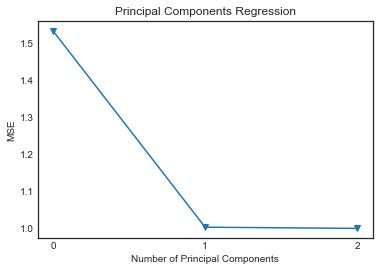

In [9]:
# Plot the pcr_mse.
ax = plt.gca()
ax.plot(pcr_mse, '-v')
plt.xticks(np.arange(p + 1))
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('MSE')
ax.set_title('Principal Components Regression')

In [10]:
# PCR test error.
X_reduced_test = pca.fit_transform(scale(X_test))[:, :min_idx]

regr = LinearRegression()
regr.fit(X_reduced[:, :min_idx], y)

pred = regr.predict(X_reduced_test)
pcr_mse_test = mean_squared_error(y_test, pred)
print(pcr_mse_test)

1.1370787279128571


In [11]:
print('OLS MSE:', ols_mse)
print('Ridge MSE:', ridge_mse)
print('PCR MSE:', pcr_mse_test)

OLS MSE: 1.3630416116754263
Ridge MSE: 1.3587973130800934
PCR MSE: 1.1370787279128571


## Exercise 2

Extend the framework described above and (initially) set $p = 50$. Propose a data generating process that

* is most suited for PCA.
* is most suited for ridge regression.
* gives the best chance for least squares to compete.

Explain the reasoning behind your choices and compare test errors across these three different methods to check
your intuition.

In [12]:
# Encapsulation.
def generate_data2(nobs, npre, k=0):
    """
    Function for generating data.
    Note: arg. k denotes how many features we are
    going to drop out, i.e., those features are 
    useless by our artificial setting. Default is
    zero.
    """
    mu = np.zeros((npre,))
    X_data = np.full((nobs, npre), np.nan)
    sigma_seq = _get_truncated_normal(n_samples=npre)
    sigma = np.diag(sigma_seq)
    X_data = np.random.multivariate_normal(mu, sigma, nobs)
    epsilon =  np.random.standard_normal(nobs)
    coe = np.random.uniform(0.1, 0.5, npre)
    coe[npre - k:npre + 1] = 0
    y_data = X_data @ coe + epsilon
    
    return X_data, y_data, coe
    
def ols_test_error(train_x, train_y, test_x, test_y):
    ols_reg = LinearRegression()
    ols_reg.fit(scale(train_x), train_y)
    ols_pred = ols_reg.predict(test_x)
    ols_mse = mean_squared_error(test_y, ols_pred)
    
    return ols_mse

def ridge_test_error(train_x, train_y, test_x, test_y):
    """
    Shrinkage penalty is chosen in the interval:
    [1e-2, 1e10].
    """
    alpha = 10 ** np.linspace(10,-2,100)

    ridgecv = RidgeCV(alphas=alpha, scoring='neg_mean_squared_error')
    ridgecv.fit(scale(train_x), train_y)

    ridge_reg = Ridge(ridgecv.alpha_)
    ridge_reg.fit(scale(train_x), train_y)
    ridge_pred = ridge_reg.predict(test_x)
    ridge_mse = mean_squared_error(test_y, ridge_pred)
    
    return ridge_mse
    
def pcr_test_error(train_x, train_y, test_x, test_y, nobs, npre):
    """
    We use 10-Fold method to calculate cv scores for selecting 
    the optimal quantity of components, which aims to be consistent
    with the default setting of R function 'pcr()'.
    
    Output:
        pcr_mse_test (float): PCR test error.
        pcr_mse (np.ndarray): 1darray of PCR 10-fold cv scores.
    """
    pca = PCA()
    X_reduced = pca.fit_transform(scale(train_x))
    
    kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)
    regr = LinearRegression()
    pcr_mse = []
    score = np.mean((-1) * cross_val_score(regr, np.ones((nobs, 1)), y, cv=kf_10,
                                          scoring='neg_mean_squared_error'))
    for i in np.arange(1, npre+1):
        score = np.mean((-1) * cross_val_score(regr, X_reduced[:, :i], y, cv=kf_10,
                                               scoring='neg_mean_squared_error'))
        pcr_mse.append(score)
    min_idx = np.argmin(pcr_mse)
    
    if min_idx == 0:
        min_idx = min_idx + 1  # Solve some index problem in python.
    
    X_reduced_test = pca.fit_transform(scale(test_x))[:, :min_idx]
    
    regr = LinearRegression()
    regr.fit(X_reduced[:, :min_idx], train_y)

    pred = regr.predict(X_reduced_test)
    pcr_mse_test = mean_squared_error(test_y, pred)
    
    return pcr_mse_test, pcr_mse

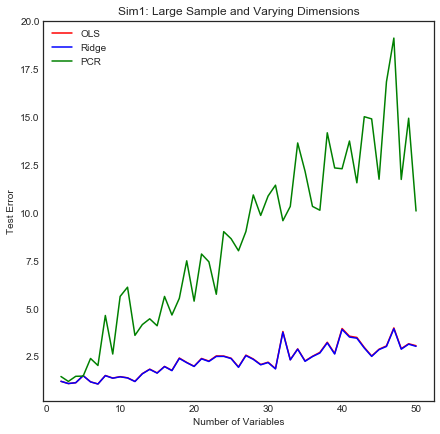

In [13]:
# Simulation 1: Large sample, data dimensionality varies #
n=1000
dim = np.arange(2,51)

mse_mat = np.full((len(dim), 3), np.nan)
for p in dim:
    X, y, beta = generate_data2(n, p)
    X_test, y_test, _ = generate_data2(n, p)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test, n, p)[0]
    
    mse_mat[p - 2, 0] = ols_mse
    mse_mat[p - 2, 1] = ridge_mse
    mse_mat[p - 2, 2] = pcr_mse

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(dim, mse_mat[:, 0], label='OLS', color='red')
ax.plot(dim, mse_mat[:, 1], label='Ridge', color='blue')
ax.plot(dim, mse_mat[:, 2], label='PCR', color='green')
ax.set_xlabel('Number of Variables')
ax.set_ylabel('Test Error')
ax.set_title('Sim1: Large Sample and Varying Dimensions')
ax.legend()

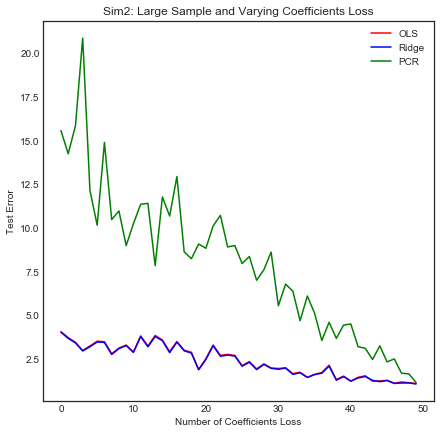

In [14]:
# Simulation 2: Large sample, predictors fixed (p=50), less betas.  #
n = 1000
p = 50
last_beta_loss = np.arange(50)

mse_mat = np.full((len(last_beta_loss), 3), np.nan)
for l in last_beta_loss:
    X, y, beta = generate_data2(n, p, k=l)
    X_test, y_test, _ = generate_data2(n, p, k=l)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test, n, p)[0]
    
    mse_mat[l, 0] = ols_mse
    mse_mat[l, 1] = ridge_mse
    mse_mat[l, 2] = pcr_mse

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(last_beta_loss, mse_mat[:, 0], label='OLS', color='red')
ax.plot(last_beta_loss, mse_mat[:, 1], label='Ridge', color='blue')
ax.plot(last_beta_loss, mse_mat[:, 2], label='PCR', color='green')
ax.set_xlabel('Number of Coefficients Loss')
ax.set_ylabel('Test Error')
ax.set_title('Sim2: Large Sample and Varying Coefficients Loss')
ax.legend()

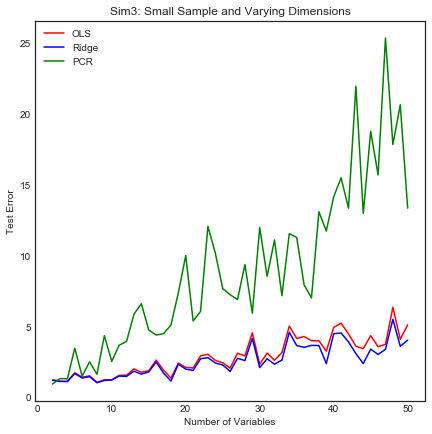

In [15]:
# Simulation 3: Small sample, data dimensionality varies #
n=100
dim = np.arange(2,51)

mse_mat = np.full((len(dim), 3), np.nan)
for p in dim:
    X, y, beta = generate_data2(n, p)
    X_test, y_test, _ = generate_data2(n, p)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test, n, p)[0]
    
    mse_mat[p - 2, 0] = ols_mse
    mse_mat[p - 2, 1] = ridge_mse
    mse_mat[p - 2, 2] = pcr_mse

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(dim, mse_mat[:, 0], label='OLS', color='red')
ax.plot(dim, mse_mat[:, 1], label='Ridge', color='blue')
ax.plot(dim, mse_mat[:, 2], label='PCR', color='green')
ax.set_xlabel('Number of Variables')
ax.set_ylabel('Test Error')
ax.set_title('Sim3: Small Sample and Varying Dimensions')
ax.legend()

Text(0.5, 0.98, 'Sim4: Small Sample and Varying Coefficients Loss')

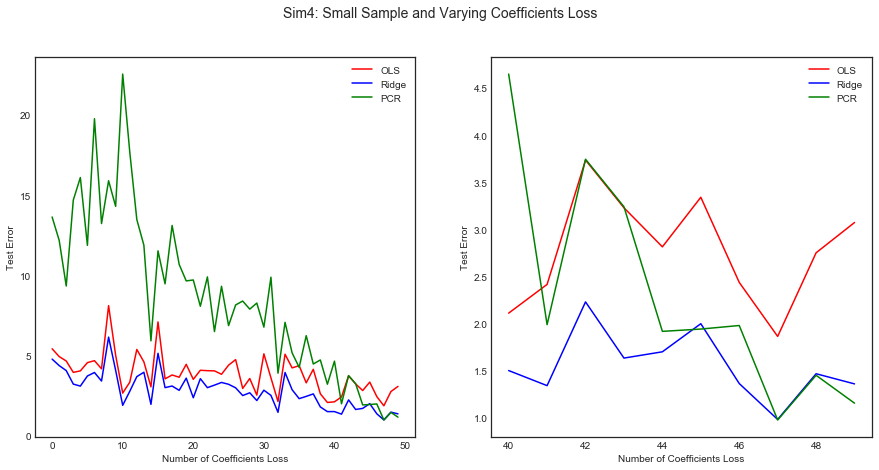

In [16]:
# Simulation 4: Small sample, predictors fixed (p=50), less betas.  #
n = 100
p = 50
last_beta_loss = np.arange(50)

mse_mat = np.full((len(last_beta_loss), 3), np.nan)
for l in last_beta_loss:
    X, y, beta = generate_data2(n, p, k=l)
    X_test, y_test, _ = generate_data2(n, p, k=l)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test,n, p)[0]
    
    mse_mat[l, 0] = ols_mse
    mse_mat[l, 1] = ridge_mse
    mse_mat[l, 2] = pcr_mse

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(last_beta_loss, mse_mat[:, 0], label='OLS', color='red')
ax1.plot(last_beta_loss, mse_mat[:, 1], label='Ridge', color='blue')
ax1.plot(last_beta_loss, mse_mat[:, 2], label='PCR', color='green')
ax1.set_xlabel('Number of Coefficients Loss')
ax1.set_ylabel('Test Error')
ax1.legend()

ax2.plot(last_beta_loss[40:], mse_mat[40:, 0], label='OLS', color='red')
ax2.plot(last_beta_loss[40:], mse_mat[40:, 1], label='Ridge', color='blue')
ax2.plot(last_beta_loss[40:], mse_mat[40:, 2], label='PCR', color='green')
ax2.set_xlabel('Number of Coefficients Loss')
ax2.set_ylabel('Test Error')
ax2.legend()

fig.suptitle('Sim4: Small Sample and Varying Coefficients Loss', fontsize=14)

Text(0.5, 0.98, 'Sim5: p = n and Varying Coefficients Loss')

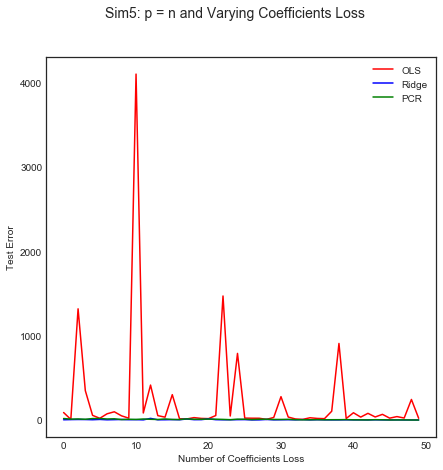

In [17]:
# Simulation 4: Smaller sample, predictors equals observations, less betas.  #
n = 50
p = 50
last_beta_loss = np.arange(50)

mse_mat = np.full((len(last_beta_loss), 3), np.nan)
for l in last_beta_loss:
    X, y, beta = generate_data2(n, p, k=l)
    X_test, y_test, _ = generate_data2(n, p, k=l)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test,n, p)[0]
    
    mse_mat[l, 0] = ols_mse
    mse_mat[l, 1] = ridge_mse
    mse_mat[l, 2] = pcr_mse

fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(last_beta_loss, mse_mat[:, 0], label='OLS', color='red')
ax1.plot(last_beta_loss, mse_mat[:, 1], label='Ridge', color='blue')
ax1.plot(last_beta_loss, mse_mat[:, 2], label='PCR', color='green')
ax1.set_xlabel('Number of Coefficients Loss')
ax1.set_ylabel('Test Error')
ax1.legend()

fig.suptitle('Sim5: p = n and Varying Coefficients Loss', fontsize=14)

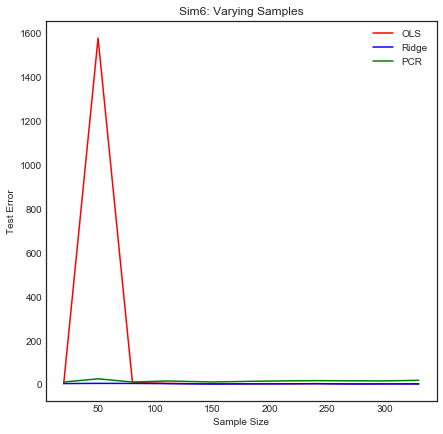

In [18]:
# Simulation 6: Varying samples, predictors fixed (p=50).  #
p = 50
n_choices = [20, 50, 80, 110, 150, 180, 210, 240, 270, 300, 330]

mse_mat = np.full((len(n_choices), 3), np.nan)
for n in n_choices:
    X, y, beta = generate_data2(n, p)
    X_test, y_test, _ = generate_data2(n, p)

    ols_mse = ols_test_error(X, y, X_test, y_test)
    ridge_mse = ridge_test_error(X, y, X_test, y_test)
    pcr_mse = pcr_test_error(X, y, X_test, y_test,n, p)[0]
    
    idx = n_choices.index(n)
    mse_mat[idx, 0] = ols_mse
    mse_mat[idx, 1] = ridge_mse
    mse_mat[idx, 2] = pcr_mse

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(n_choices, mse_mat[:, 0], label='OLS', color='red')
ax.plot(n_choices, mse_mat[:, 1], label='Ridge', color='blue')
ax.plot(n_choices, mse_mat[:, 2], label='PCR', color='green')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Test Error')
ax.set_title('Sim6: Varying Samples')
ax.legend()